306


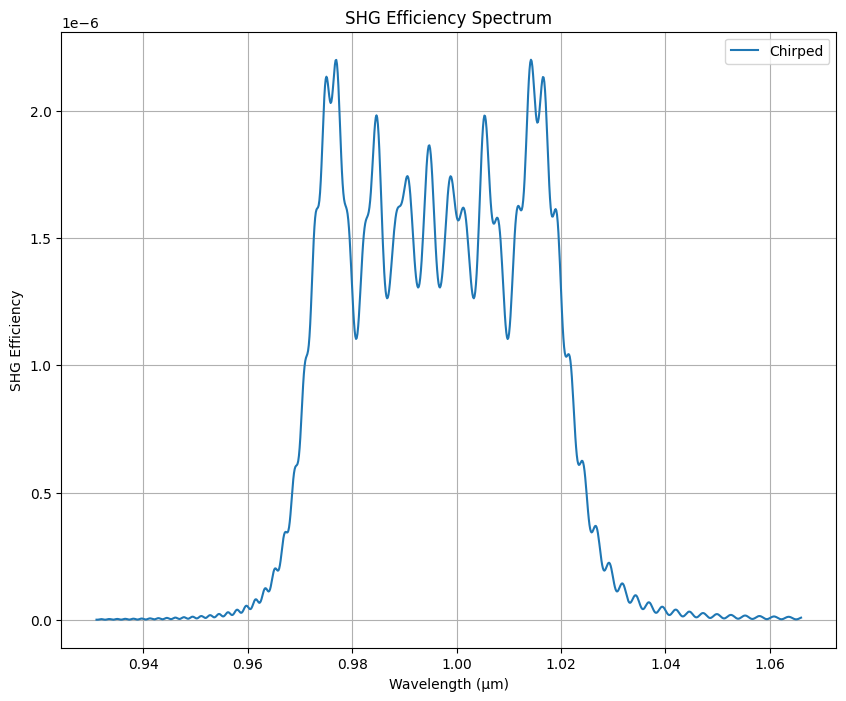

In [ ]:
from syuron import shg3
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import List


def create_chirped_domains(L: float, Lambda0: float, kappa_val: float, chirp_rate: float = 0.0) -> List[shg3.Domain]:
    domains = []
    z = 0.0
    i = 0
    while z < L:
        current = Lambda0 / (1 + chirp_rate * z)
        width = current / 2
        kappa = kappa_val if i % 2 == 0 else -kappa_val
        domains.append(shg3.Domain(width, kappa))
        z += current
        i += 1
    return domains


domain_stack = create_chirped_domains(2000, 7.2, 1.031E-05, 0.0001)
print(len(domain_stack))

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg3.Params(
    domain_stack_dim=domain_stack,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=300
)

eff_tensor = shg3.analyze(params, shg3.use_mgoslt, shg3.solve_ncme)

plt.figure(figsize=(10, 8))
plt.plot(wavelength_dim, eff_tensor[0, 0, :, 0, 0], label="Chirped")
plt.xlabel("Wavelength (μm)")
plt.ylabel("SHG Efficiency")
plt.title("SHG Efficiency Spectrum")
plt.legend()
plt.grid(True)
plt.show()